# Introdução a Bancos de Dados Vetorizados e Similaridade entre Embeddings

Notebook introdutório para apresentações sobre representações vetoriais, métricas de proximidade e bancos vetorizados (com foco em Postgres + pgvector).


## Objetivos
- Explicar o que são embeddings e por que precisamos deles.
- Mostrar visualmente vetores como pontos em um espaço.
- Comparar dot product, cosine similarity e distância euclidiana.
- Conectar os conceitos com bancos vetorizados (pgvector, IVFFlat, HNSW).
- Preparar os próximos notebooks com demonstrações aprofundadas.


## Configuração do Ambiente

Antes de executar as demonstrações, é recomendado criar um ambiente virtual isolado para gerenciar as dependências do projeto.


### Criando um ambiente virtual

Execute os comandos abaixo no terminal (fora do Jupyter) para criar e ativar um ambiente virtual:

**Windows (PowerShell):**
```powershell
python -m venv venv
.\venv\Scripts\Activate.ps1
```

**Linux/Mac:**
```bash
python3 -m venv venv
source venv/bin/activate
```

> **Nota:** Se você estiver usando Jupyter Notebook/Lab, pode precisar instalar o kernel do ambiente virtual:
> ```bash
> pip install ipykernel
> python -m ipykernel install --user --name=venv --display-name "Python (venv)"
> ```
> Depois, selecione o kernel "Python (venv)" no menu do Jupyter.


In [ ]:
# Verificar se estamos em um ambiente virtual (opcional)
import sys
import os

print("Verificando ambiente Python...")
print(f"Versão Python: {sys.version.split()[0]}")
print(f"Caminho do interpretador: {sys.executable}")

if hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix):
    print(f"✓ Ambiente virtual ativo: {sys.prefix}")
else:
    print("⚠ Não detectado ambiente virtual. Recomenda-se criar um antes de continuar.")
    print("   Execute no terminal: python -m venv venv")
    print("   Depois ative: .\\venv\\Scripts\\Activate.ps1 (Windows) ou source venv/bin/activate (Linux/Mac)")

print("\nVocê pode continuar mesmo sem ambiente virtual, mas é recomendado usar um.")


⚠ Não detectado ambiente virtual. Recomenda-se criar um antes de continuar.
   Execute: python -m venv venv


## O que são embeddings?
Embeddings são vetores de números reais que codificam o significado de textos, imagens, usuários ou itens. Eles posicionam cada objeto em um espaço contínuo de forma que proximidade espacial corresponda a proximidade semântica.


### Por que são importantes?
- **Busca semântica:** encontra documentos relacionados mesmo sem termos idênticos.
- **Recomendação:** ranqueia itens parecidos com o perfil do usuário.
- **Deduplicação e segurança:** detecta versões similares de um conteúdo.
- **Assistentes conversacionais:** mantém memória e contexto em múltiplos turnos.


### Onde aparecem na prática?
- Marketplace: destacar produtos complementares.
- Atendimento: sugerir respostas em bases de conhecimento.
- Finanças: monitorar notícias semelhantes que impactam um ativo.
- RH Tech: mensurar afinidade entre vagas e candidatos.


## Intuição geométrica
- Vetores são pontos em um espaço n-dimensional.
- Similaridade corresponde à proximidade desses pontos.
- Em 2D/3D conseguimos visualizar ângulos e distâncias para criar uma explicação intuitiva que vale para dimensões maiores.


### Dependências leves
Use apenas bibliotecas padrão. Caso esteja em um ambiente novo, execute a célula abaixo (opcional):


In [7]:
# Instalar dependências necessárias
%pip install --quiet numpy pandas matplotlib

# Verificar se as bibliotecas foram instaladas corretamente
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    print("✓ Todas as dependências foram instaladas com sucesso!")
except ImportError as e:
    print(f"✗ Erro ao importar bibliotecas: {e}")
    print("Tente executar: %pip install numpy pandas matplotlib")



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
✓ Todas as dependências foram instaladas com sucesso!


In [8]:
# Importar bibliotecas (já verificadas na célula anterior)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configurar semente para reprodutibilidade
np.random.seed(7)

# Configurar estilo do matplotlib
try:
    plt.style.use("seaborn-v0_8")
except OSError:
    # Fallback para versões mais antigas do matplotlib
    plt.style.use("seaborn")


## Métricas de similaridade
As três métricas mais populares em aplicações com embeddings:


1. **Dot Product (Produto Interno):** valor alto indica vetores apontando para a mesma direção e magnitude elevada.
2. **Cosine Similarity:** normaliza o comprimento e mede apenas o ângulo.
3. **Euclidean Distance:** distância direta entre dois pontos.


### Fórmulas amigáveis
Para vetores `a` e `b`:
- `dot(a, b) = Σ (a_i * b_i)`
- `cos(a, b) = dot(a, b) / (||a|| * ||b||)`
- `d(a, b) = sqrt(Σ (a_i - b_i)^2)`

> Dot/Cos retornam "quanto maior, mais parecido". Distância retorna "quanto menor, mais próximo".


## Demonstração prática


In [9]:
NUM_POINTS = 5
vectors = np.random.randn(NUM_POINTS, 2)
labels = [f"v{i+1}" for i in range(NUM_POINTS)]

df_vectors = pd.DataFrame(vectors, columns=["x", "y"])
df_vectors["label"] = labels
df_vectors


,x,y,label
0,1.690526,-0.465937,v1
1,0.032820,0.407516,v2
2,-0.788923,0.002066,v3
3,-0.000890,-1.754724,v4
4,1.017658,0.600499,v5


In [10]:
def dot_product(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(a, b))


def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)


def euclidean_distance(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.linalg.norm(a - b))


anchor = vectors[0]
comparisons = vectors[1:]

rows = []
for label, vec in zip(labels[1:], comparisons):
    rows.append(
        {
            "par": f"{labels[0]} vs {label}",
            "dot": dot_product(anchor, vec),
            "cosine": cosine_similarity(anchor, vec),
            "euclidean": euclidean_distance(anchor, vec),
        }
    )

metrics_df = pd.DataFrame(rows)
metrics_df


,par,dot,cosine,euclidean
0,v1 vs v2,-0.134394,-0.187460,1.873742
1,v1 vs v3,-1.334657,-0.964746,2.523231
2,v1 vs v4,0.816086,0.265220,2.126467
3,v1 vs v5,1.440582,0.695247,1.260966


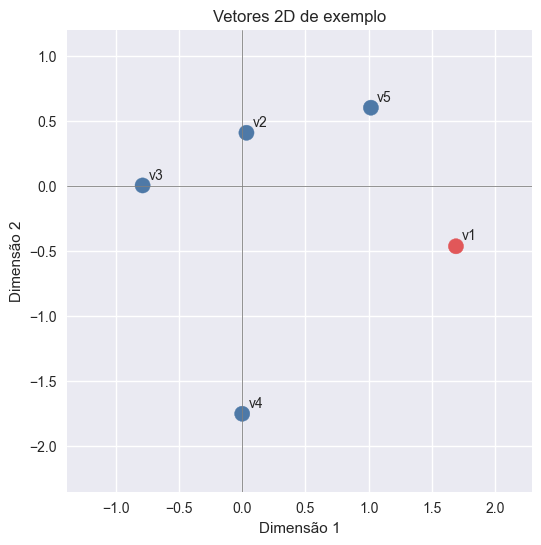

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
colors = ["#E15759"] + ["#4E79A7"] * (NUM_POINTS - 1)
ax.scatter(df_vectors["x"], df_vectors["y"], c=colors, s=120)

for _, row in df_vectors.iterrows():
    ax.annotate(row["label"], (row["x"] + 0.05, row["y"] + 0.05))

ax.axhline(0, color="gray", linewidth=0.6)
ax.axvline(0, color="gray", linewidth=0.6)
ax.set_title("Vetores 2D de exemplo")
ax.set_xlabel("Dimensão 1")
ax.set_ylabel("Dimensão 2")
ax.set_xlim(df_vectors["x"].min() - 0.6, df_vectors["x"].max() + 0.6)
ax.set_ylim(df_vectors["y"].min() - 0.6, df_vectors["y"].max() + 0.6)
plt.show()


### Interpretação rápida
- **Dot Product:** considera magnitude + alinhamento; ideal quando embeddings carregam pesos ou probabilidades.
- **Cosine Similarity:** ignora magnitude e foca no ângulo; ótima para textos de tamanhos diferentes.
- **Euclidean Distance:** distância direta; intuitiva quando vetores já estão normalizados ou descrevem coordenadas físicas.


## Bancos vetorizados em alto nível
Armazenar milhões de embeddings exige estruturas otimizadas para buscar vizinhos rapidamente.


### Postgres + pgvector
- Adiciona o tipo `vector` ao Postgres, permitindo armazenar embeddings lado a lado com dados relacionais.
- Suporta consultas com `dot_product`, `cosine_distance` e `euclidean_distance` diretamente em SQL.
- Índices ANN disponíveis:
  - **IVFFlat:** organiza vetores em listas invertidas; ótimo para bases grandes, requer `ANALYZE` após cargas.
  - **HNSW:** grafo hierárquico navegável, excelente precisão e latência baixa com custo de memória maior.
- Escolha a métrica ao criar o índice (`vector_ip_ops`, `vector_cosine_ops`, `vector_l2_ops`) para alinhar com o comportamento do modelo.


### Quando usar cada métrica?
| Cenário | Métrica | Motivação |
| --- | --- | --- |
| Ranking com pesos embutidos (popularidade, confiança) | Dot Product | Mantém magnitude absoluta dos vetores.
| Textos de tamanhos distintos / pura semântica | Cosine Similarity | Normaliza comprimento e mede apenas o ângulo.
| Dados normalizados ou coordenadas físicas | Euclidean Distance | Distância direta, intuitiva para clustering/limites.


## Conclusão
- Embeddings traduzem contexto em números comparáveis.
- Dot Product, Cosine e Euclidean oferecem perspectivas complementares.
- pgvector leva essas métricas para dentro do Postgres com índices ANN (IVFFlat/HNSW).
- **Próximos notebooks:** veremos casos completos para cada métrica (recomendação, busca semântica e clustering).
